# EDA for Predict the Introverts from the Extroverts

In [34]:
from scipy.stats import chi2_contingency
import numpy as np 
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore",  category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning,)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

## 1. Basic check of data

In [80]:
display(train_df.head(4))
display(test_df.head(4))

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0


In [99]:
display(train_df.info())
print('')
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         6175 non-null   int64  
 1   Time_spent_Alone           5750 non-null   float64
 2   Stage_fear                 5577 non-null   object 
 3   Social_event_attendance    5778 non-null   float64
 4   Going_outside              5709 non-null   float64
 5   Drained_after_socializing  5743 non-null   object 
 6   Friends_circle_size        5825 non-null   float64
 7   Post_frequency             5767 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 386.1+ KB


None

In [95]:
display("Summary for TRAIN data:",train_df.describe())
display("Summary for TEST data:",test_df.describe())

'Summary for TRAIN data:'

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


'Summary for TEST data:'

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,6175.000000,5750.000000,5778.000000,5709.000000,5825.000000,5767.000000
mean,21611.000000,3.116870,5.287989,4.037835,8.008412,5.028958
std,1782.713288,2.985658,2.758052,2.045207,4.192701,2.867285
min,18524.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20067.500000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,21611.000000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,23154.500000,4.000000,8.000000,6.000000,12.000000,7.000000
max,24698.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [90]:
display("TRAIN data", train_df.nunique())
print('\n')
display('TEST data',test_df.nunique())

'TRAIN data'

id                           18524
Time_spent_Alone                12
Stage_fear                       2
Social_event_attendance         11
Going_outside                    8
Drained_after_socializing        2
Friends_circle_size             16
Post_frequency                  11
Personality                      2
dtype: int64

'TEST data'

id                           6175
Time_spent_Alone               12
Stage_fear                      2
Social_event_attendance        11
Going_outside                   8
Drained_after_socializing       2
Friends_circle_size            16
Post_frequency                 11
dtype: int64

### Key Observations:
- We have 5 numeric columns and 2 with categories, One coulmn with id in both train/test sets and additional column with labels in train
- train/test sets have same min max values and similar statistics
- train/test sets have have same number of unique values

## 2. Duplicates and missing values check

In [92]:
display("Duplicates in TRAIN data:", train_df.duplicated().sum())
display("Duplicates in TEST data:", test_df.duplicated().sum())

'Duplicates in TRAIN data:'

0

'Duplicates in TEST data:'

0

In [93]:
print("Missing values in TRAIN data:\n",train_df.isna().mean().apply(lambda x: f"{x:.2%}"))
print("\nMissing values  in TEST data:\n",test_df.isna().mean().apply(lambda x: f"{x:.2%}"))

Missing values in TRAIN data:
 id                            0.00%
Time_spent_Alone              6.42%
Stage_fear                   10.22%
Social_event_attendance       6.37%
Going_outside                 7.91%
Drained_after_socializing     6.20%
Friends_circle_size           5.69%
Post_frequency                6.82%
Personality                   0.00%
dtype: object

Missing values  in TEST data:
 id                           0.00%
Time_spent_Alone             6.88%
Stage_fear                   9.68%
Social_event_attendance      6.43%
Going_outside                7.55%
Drained_after_socializing    7.00%
Friends_circle_size          5.67%
Post_frequency               6.61%
dtype: object


<Axes: title={'center': 'Missing values in % for train and test'}>

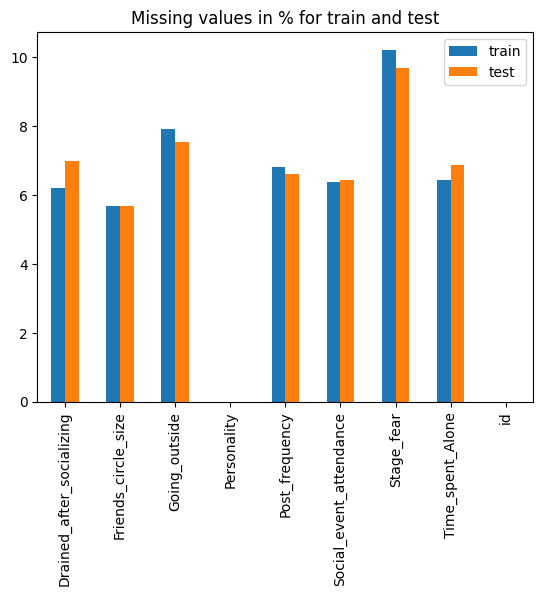

In [11]:
missing_data= pd.DataFrame({
    'train': train_df.isna().mean()*100,
    'test': test_df.isna().mean()*100
})
missing_data.plot(kind='bar', title='Missing values in % for train and test')

### Key Observations:
- There is no duplicates in train/test data
- There are missing data in train/test sets in range 5.6% to 10.2% depending on coulumn
- Stage_fear column has the largest amount of missing data, rest of columns have comparable number of missing values
- There is no major difference in the amount of missing data between train/test data

## 3. Train-Test drift check

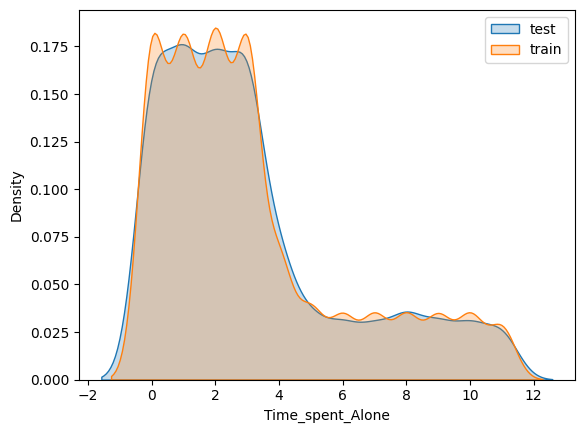

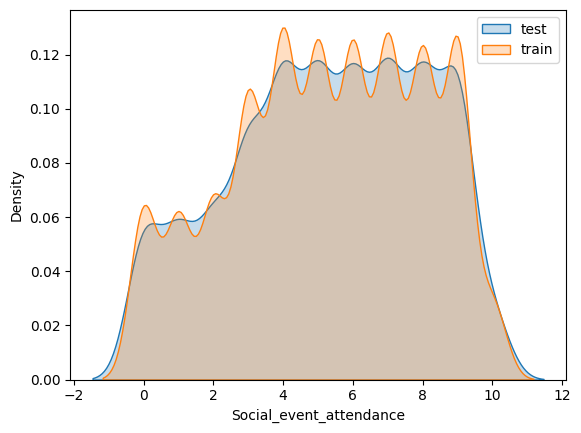

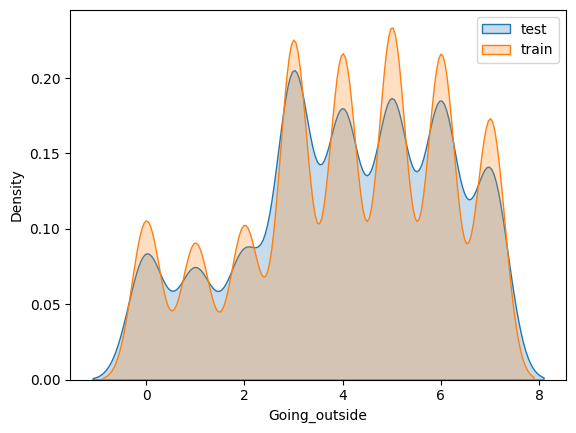

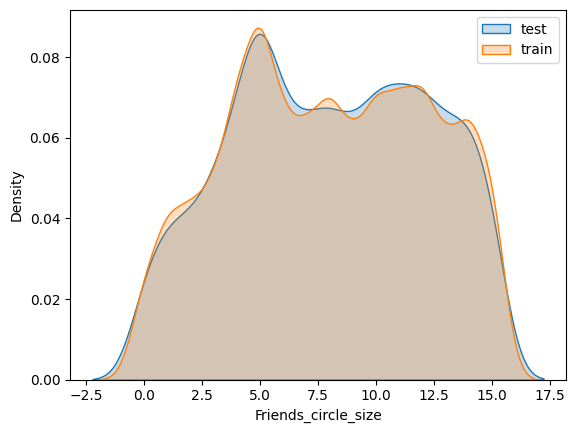

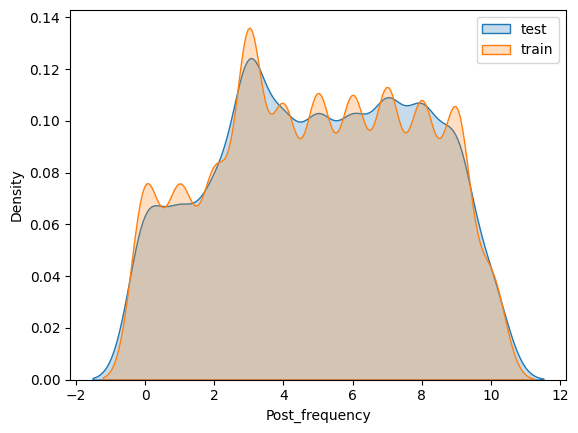

In [13]:
for col in test_df.columns:
    if col != 'id' and test_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(test_df[col], label='test', fill=True)
        sns.kdeplot(train_df[col], label='train', fill=True)
        plt.legend()
        plt.show()

### Key Observations:
- no clear drift between train and test data

## 4. Correlation check for train and test data

<Axes: >

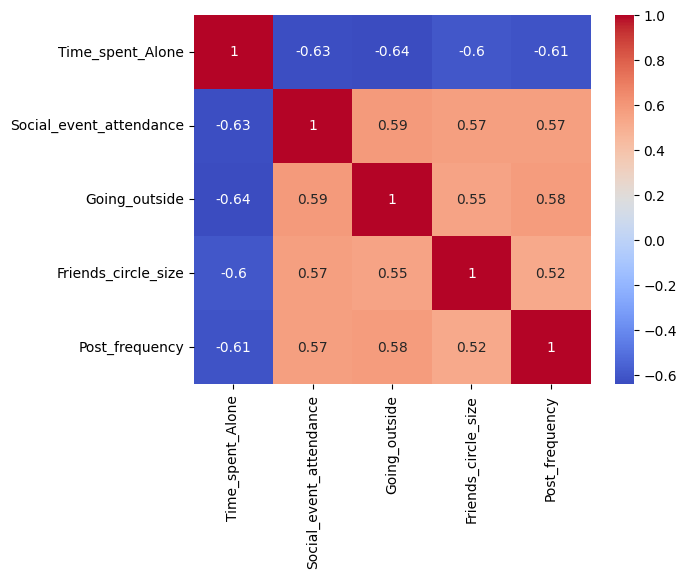

In [14]:
sns.heatmap(train_df[['Time_spent_Alone', 'Social_event_attendance','Going_outside', 'Friends_circle_size','Post_frequency']].corr(),
            annot = True, cmap='coolwarm')

<Axes: >

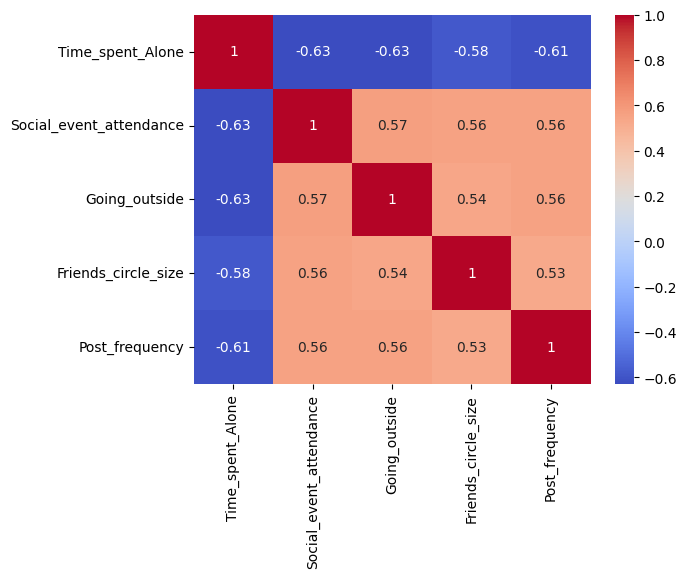

In [15]:
sns.heatmap(test_df[['Time_spent_Alone', 'Social_event_attendance','Going_outside', 'Friends_circle_size','Post_frequency']].corr(), 
            annot = True, cmap='coolwarm')

### Key Observations:
- The Time_spend_alone column has a clearly higher correlation with all the other columns
- The remaining columns have a weak correlation with each other
- The correlations for training and test data look very similar

# 5. Check of 'personality' in each column for train data

Personality
Extrovert    73.95
Introvert    26.05
Name: proportion, dtype: float64

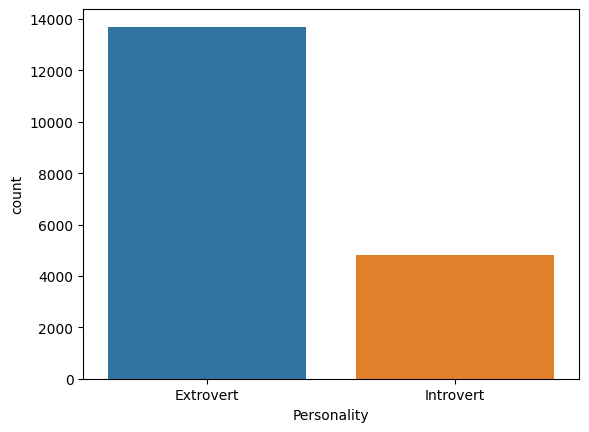

In [105]:
sns.countplot(data=train_df, x='Personality')
round(train_df['Personality'].value_counts(normalize=True)*100,2)

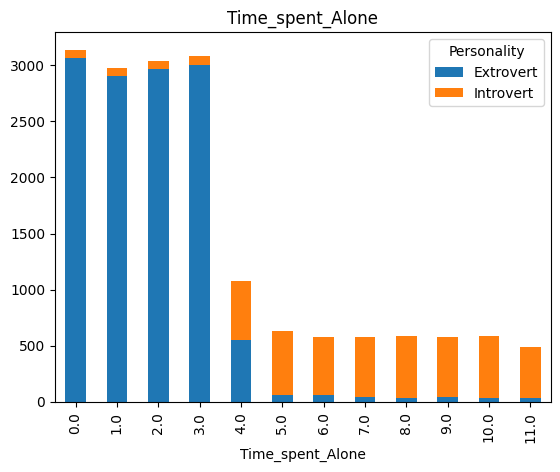

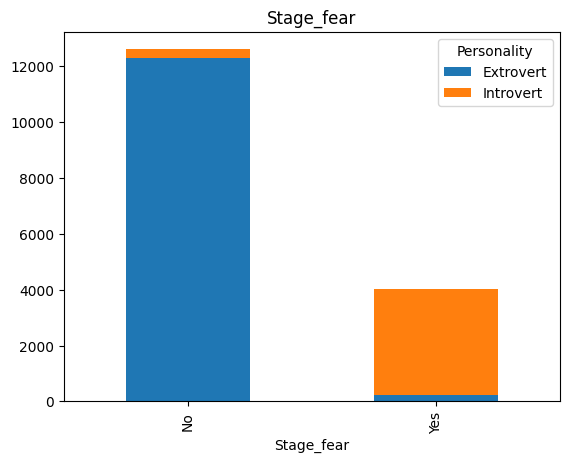

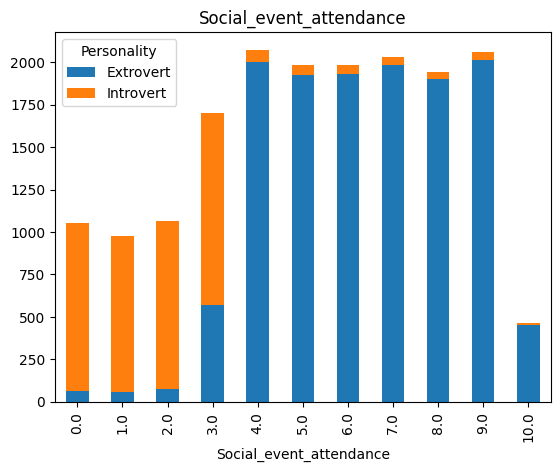

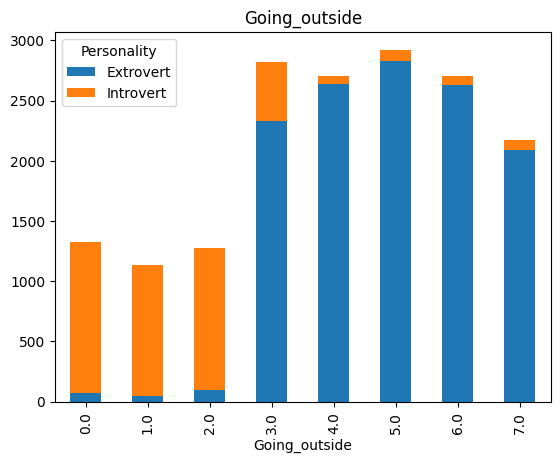

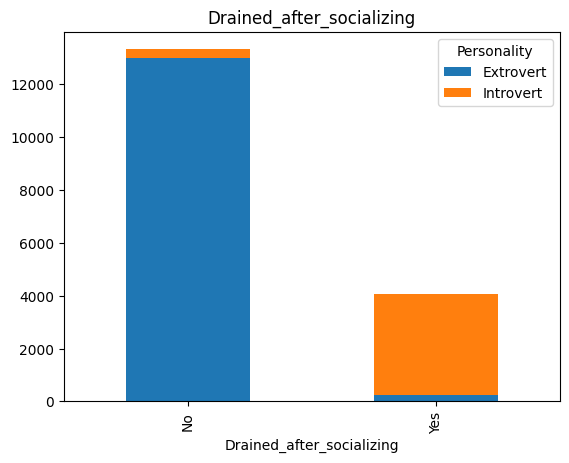

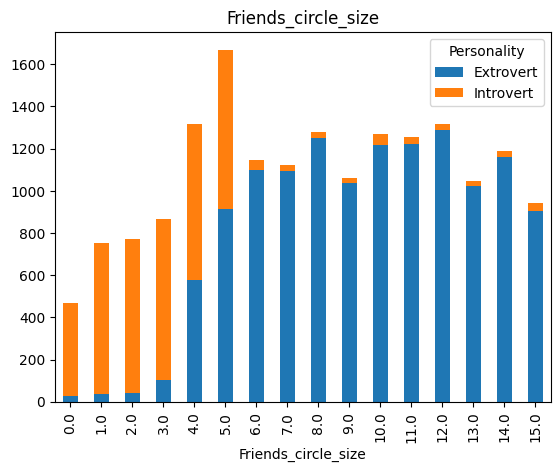

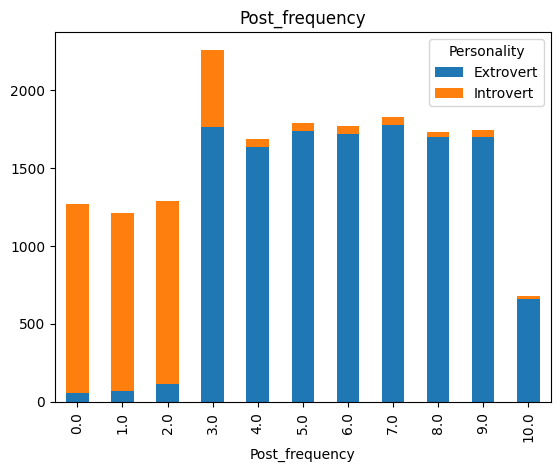

In [16]:
columns = [col for col in test_df.columns if col != 'id']
for col in columns:
    train_df.groupby([col,'Personality']).size().unstack().plot(kind='bar', stacked=True, title=col)

### Key Observations:
- We have 2 gropus in label column with split 74% 26% - classes are not balanced
- Data in numeric column are integer
- Each column show integer values dominated by one group, transition integer values and values dominated by other group
- Stage_fear and Drained_after_socializing columns show strong polarisation of data and similar character
- There is no clear integer values column that is only introvert or extrovert

## 6. Detailed check of categorical columns properties

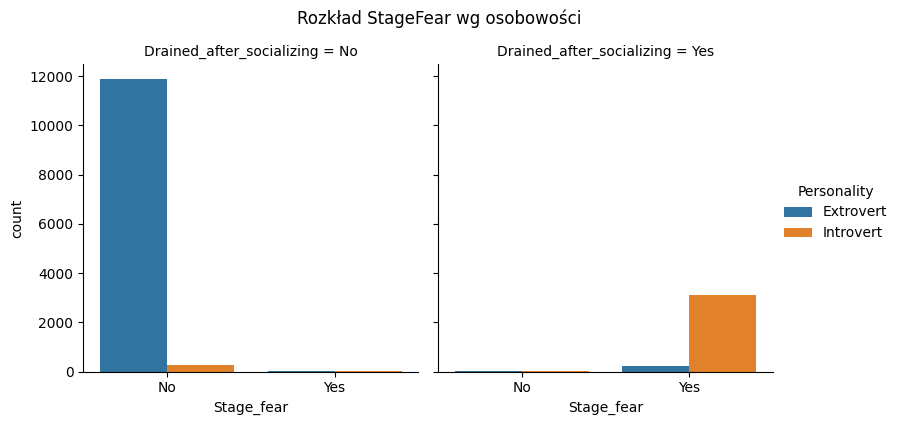

In [17]:
sns.catplot(
    data=train_df[train_df['Personality'].isin(['Introvert', 'Extrovert'])],  
    x="Stage_fear",
    hue="Personality",
    col="Drained_after_socializing",
    kind="count",
    height=4,
    aspect=1
)
plt.suptitle("Rozkład StageFear wg osobowości", y=1.05)
plt.show()

In [18]:
pd.crosstab([train_df['Personality'],train_df["Stage_fear"]],train_df["Drained_after_socializing"]  )

Drained_after_socializing     No   Yes
Personality Stage_fear                
Extrovert   No             11882     9
            Yes                5   207
Introvert   No               279     6
            Yes                8  3125

### Key Observations:
- Stage_fear and Drained_after_socializing columns seems to be strong indicator of classification
- In each column there is small representation of opposite group prefference (Extrovert preffers No & No, but there is small group of introverts with same prefferences)
- It is very rare situation to have Yes - No and No - Yes answers. It is very specific minor group
- It may be resonable to impute data Yes when other column is Yes and oposite for No, for such rare cases


####  Below we check what would be result of imputation Yes to Yes and No to No for both ways

In [5]:
cat_cols1 = ['Stage_fear','Drained_after_socializing']
all_train_df=train_df[['Stage_fear','Drained_after_socializing','Personality']].copy()
all_train_df[cat_cols1]=all_train_df[cat_cols1].fillna('Missing').astype(str)
display(pd.crosstab([all_train_df['Personality'],all_train_df["Stage_fear"]],all_train_df["Drained_after_socializing"]  ))


help_train_df = train_df[['Stage_fear','Drained_after_socializing','Personality']].copy()
help_train_df['Stage_fear'] = help_train_df['Stage_fear'].mask(help_train_df['Stage_fear'].isna() & help_train_df['Drained_after_socializing']
                                            .notna(), help_train_df['Drained_after_socializing'])
help_train_df['Drained_after_socializing'] = help_train_df['Drained_after_socializing'].mask(help_train_df['Drained_after_socializing']
                                            .isna() & help_train_df['Stage_fear'].notna(), help_train_df['Stage_fear'])
help_train_df[cat_cols1]=help_train_df[cat_cols1].fillna('Missing').astype(str)

display(pd.crosstab(help_train_df['Stage_fear'],help_train_df['Personality']))

Drained_after_socializing  Missing     No   Yes
Personality Stage_fear                         
Extrovert   Missing             15   1114    20
            No                 423  11882     9
            Yes                 24      5   207
Introvert   Missing             24     25   695
            No                  10    279     6
            Yes                653      8  3125

Personality,Extrovert,Introvert
Stage_fear,,
Missing,15,24
No,13428,320
Yes,256,4481


### Key Observations:
- There is only 39 missing values for both categorical columns and for total 18524 rows it seems to be a good imputation stratego - to be tested

## 7. Detailed check of No-No / Yes-Yes data regarding Introverts & Extroverts groups

In [18]:
train_introvert_df = train_df[train_df['Personality']=='Introvert']
train_extrovert_df = train_df[train_df['Personality']=='Extrovert']

In [19]:
introvert_no_no_df = train_df[(train_df["Stage_fear"]=='No') & (train_df["Drained_after_socializing"]=='No') & (train_df['Personality']=='Introvert')]
extrovert_yes_yes_df = train_df[(train_df["Stage_fear"]=='Yes') & (train_df["Drained_after_socializing"]=='Yes') & (train_df['Personality']=='Extrovert')]

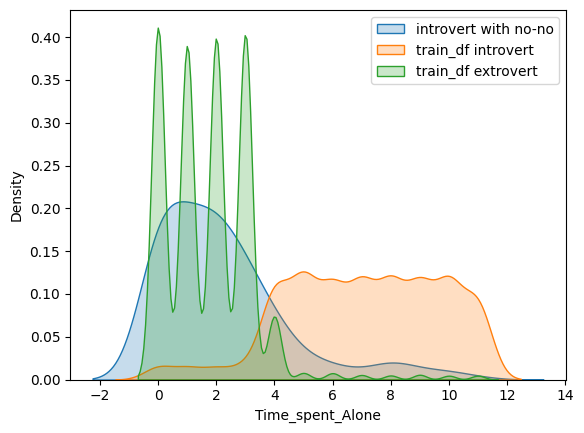

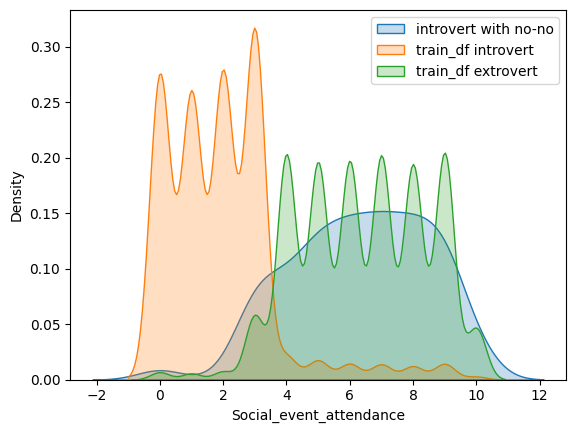

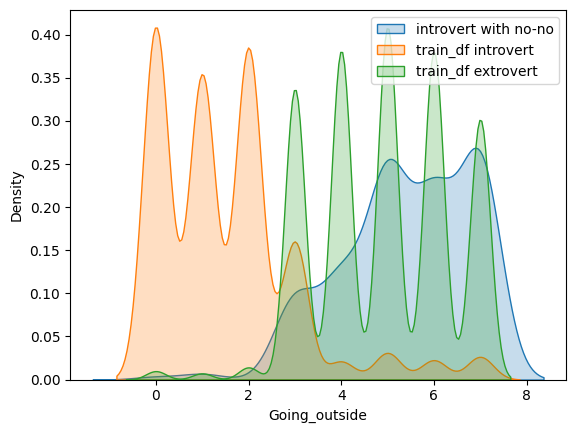

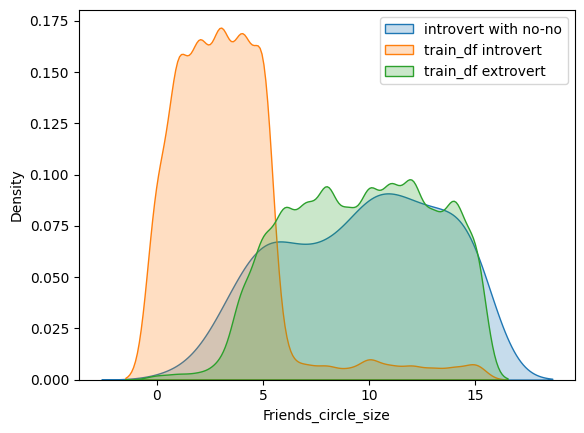

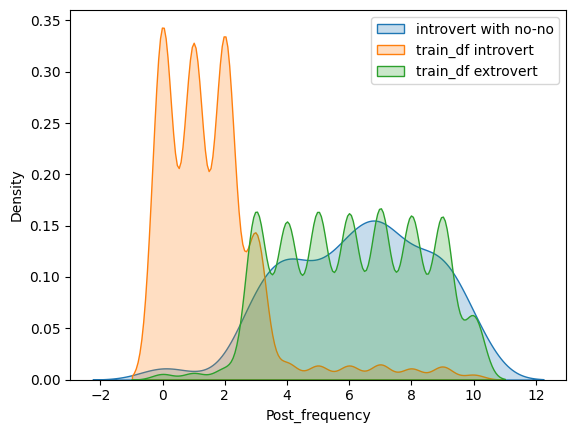

In [20]:
for col in columns:
    if train_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(introvert_no_no_df[col], label='introvert with no-no', fill=True)
        sns.kdeplot(train_introvert_df[col], label='train_df introvert', fill=True)
        sns.kdeplot(train_extrovert_df[col], label='train_df extrovert', fill=True)
        plt.legend()
        plt.show()

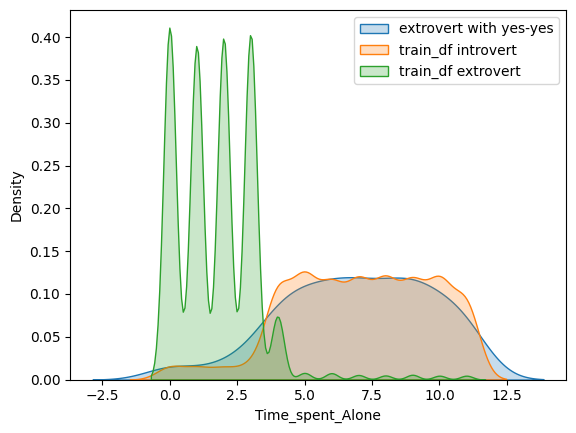

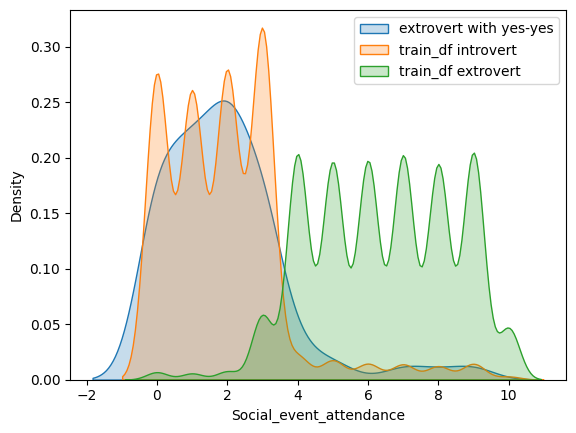

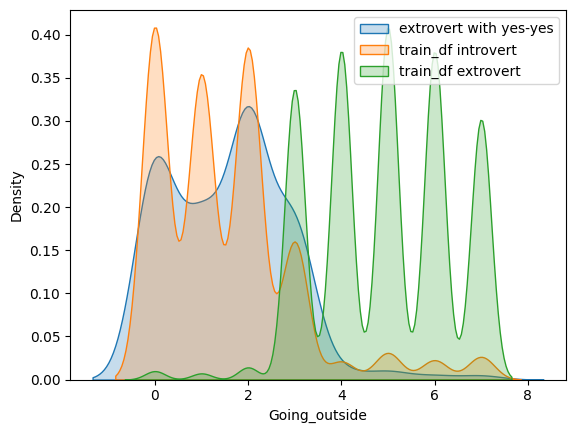

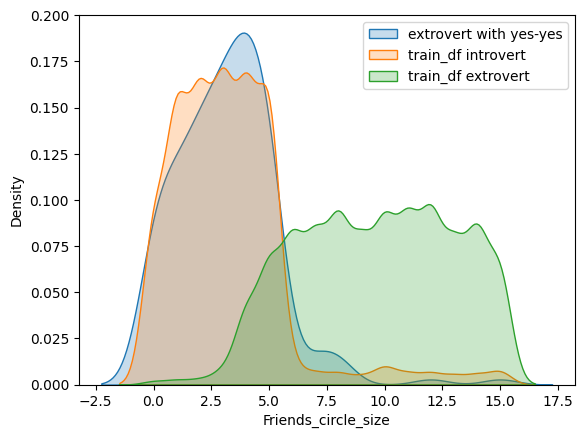

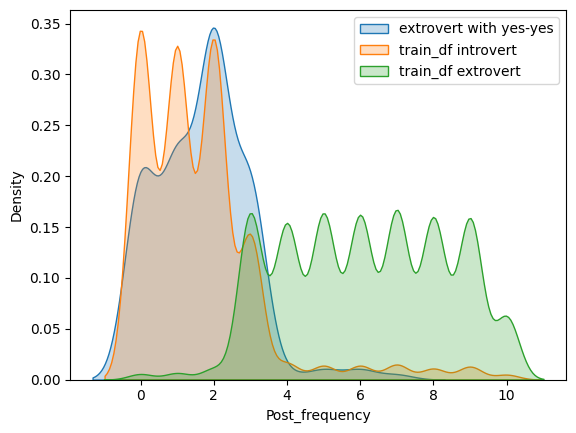

In [21]:
for col in columns:
    if train_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(extrovert_yes_yes_df[col], label='extrovert with yes-yes', fill=True)
        sns.kdeplot(train_introvert_df[col], label='train_df introvert', fill=True)
        sns.kdeplot(train_extrovert_df[col], label='train_df extrovert', fill=True)
        plt.legend()
        plt.show()

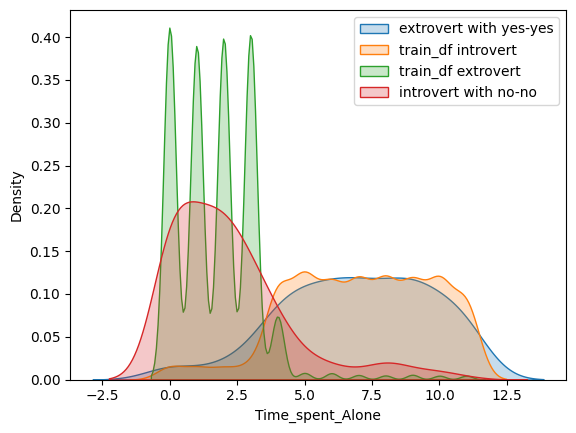

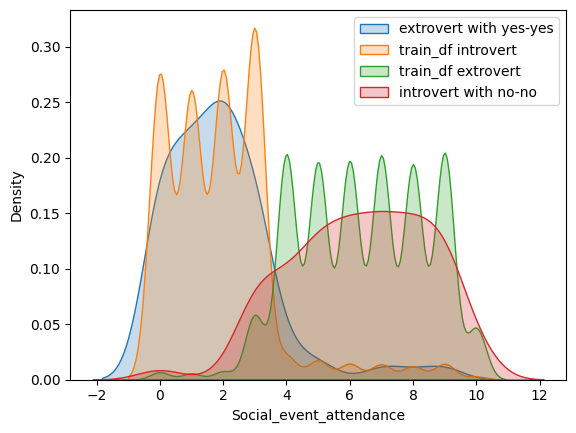

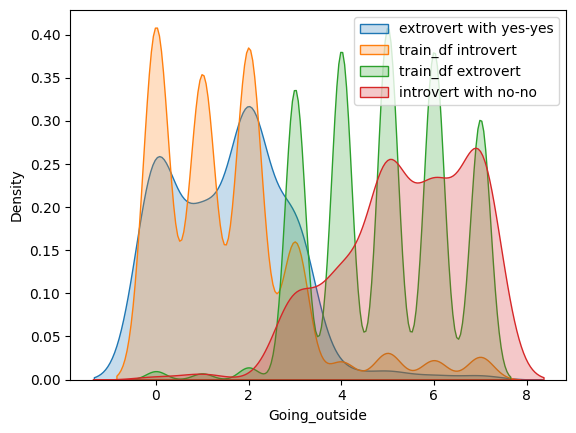

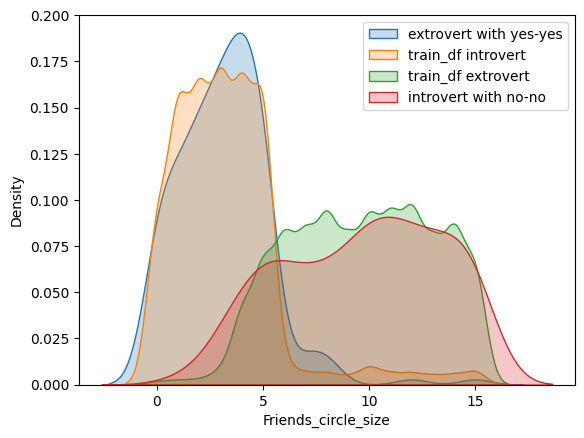

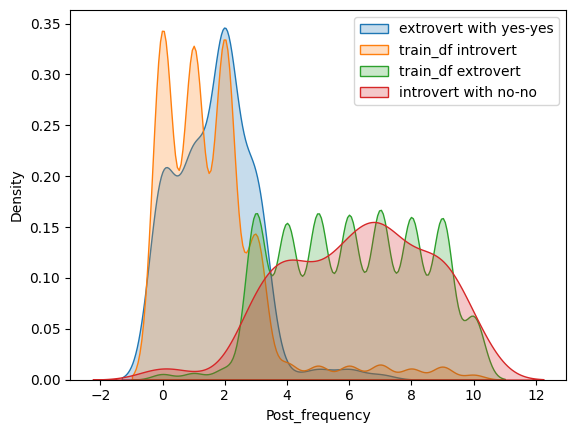

In [22]:
for col in columns:
    if train_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(extrovert_yes_yes_df[col], label='extrovert with yes-yes', fill=True)
        sns.kdeplot(train_introvert_df[col], label='train_df introvert', fill=True)
        sns.kdeplot(train_extrovert_df[col], label='train_df extrovert', fill=True)
        sns.kdeplot(introvert_no_no_df[col], label='introvert with no-no', fill=True)
        plt.legend()
        plt.show()

### Key Observations:
- It seems like main problem of this classification. No-No answer is typical for Extroverts but some Introverts have same prefferences like No-No and has similar values for other colums (Post_frequency, Going_outsice...) like Extroverts
- It will be extremly hard for classifiers to deal with such situation. There is some space in overlaping area between yes-yes and no-no groups and it can be marked with 0 and 1 giving clear information to model that is border condition. - Can be tested 

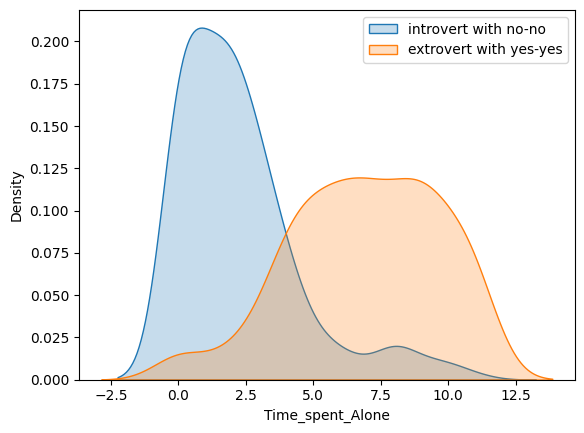

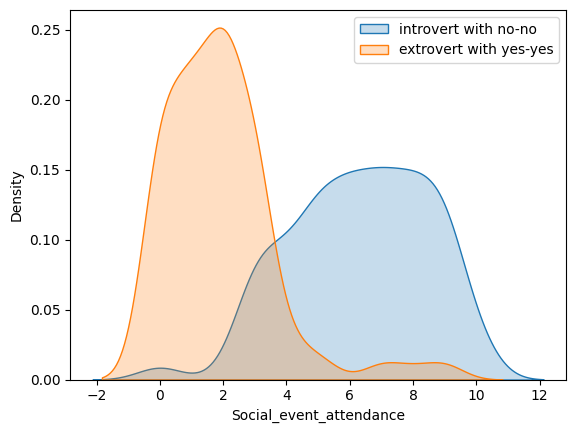

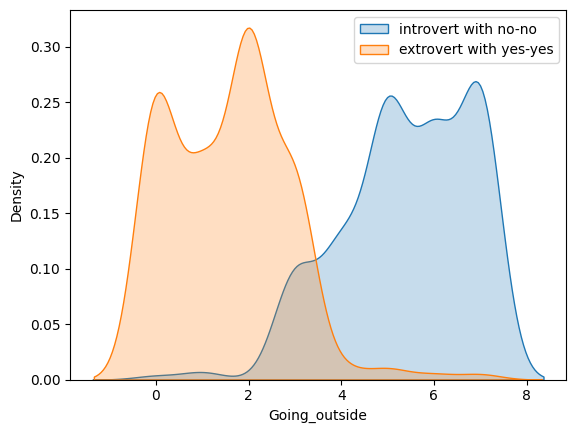

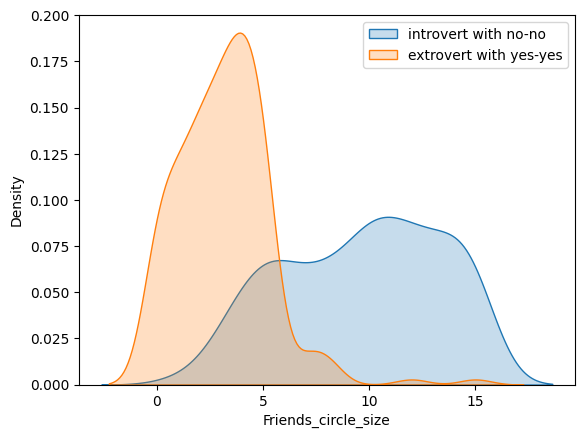

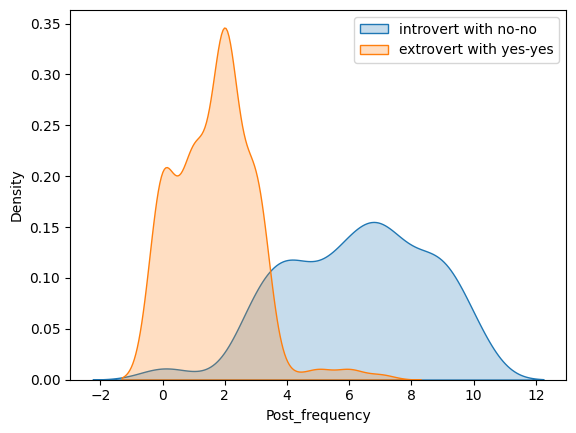

In [29]:
for col in test_df.columns:
    if col != 'id' and test_df[col].dtype in[np.int64,np.float64]:
        sns.kdeplot(introvert_no_no_df[col], label='introvert with no-no', fill=True)
        sns.kdeplot(extrovert_yes_yes_df[col], label='extrovert with yes-yes', fill=True)

        plt.legend()
        plt.show()

### Markers to be tested:
- 'Time_spent_Alone' == 4
- 'Social_event_attendance' == 3
- 'Going_outside' ==3
- 'Friends_circle_size' == 5
- 'Post_frequency' == 3

## 8. Missing values - looking for signals

In [31]:
excluded_cols = ['id', 'Personality']
all_columns = train_df.columns
for col in all_columns:
    if col not in excluded_cols:
        train_df[col + '_MISS'] = train_df[col].notna().astype(int)

Chi2 = 0.069, p-value = 0.7935 Column: Time_spent_Alone_MISS 
Chi2 = 4.359, p-value = 0.0368 Column: Stage_fear_MISS 
Chi2 = 3.183, p-value = 0.0744 Column: Social_event_attendance_MISS 
Chi2 = 1.546, p-value = 0.2137 Column: Going_outside_MISS 
Chi2 = 25.141, p-value = 0.0000 Column: Drained_after_socializing_MISS 
Chi2 = 1.174, p-value = 0.2786 Column: Friends_circle_size_MISS 
Chi2 = 3.540, p-value = 0.0599 Column: Post_frequency_MISS 


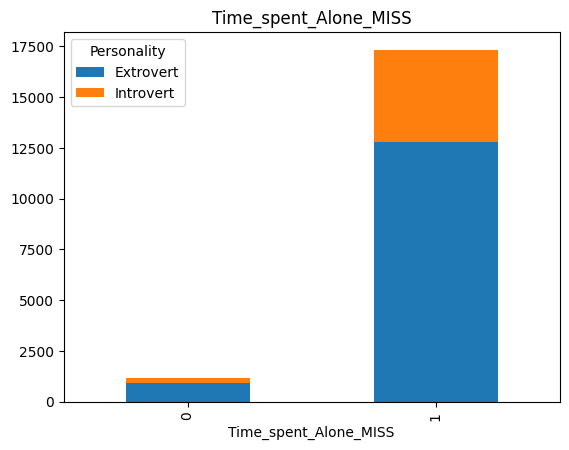

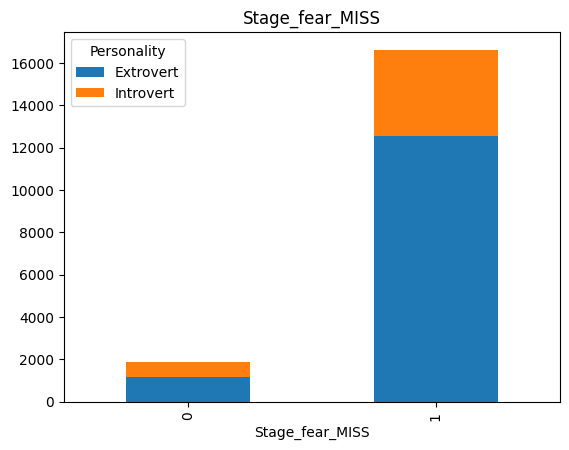

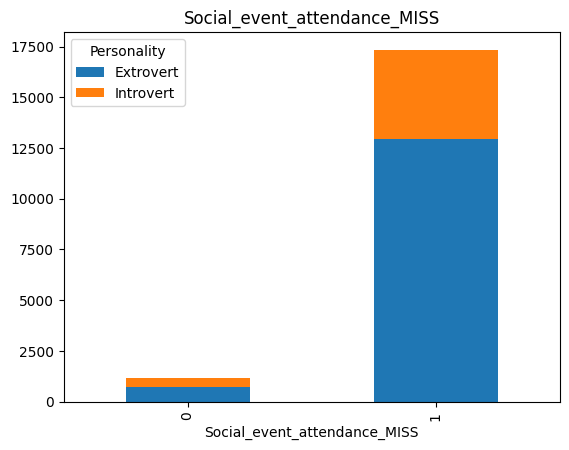

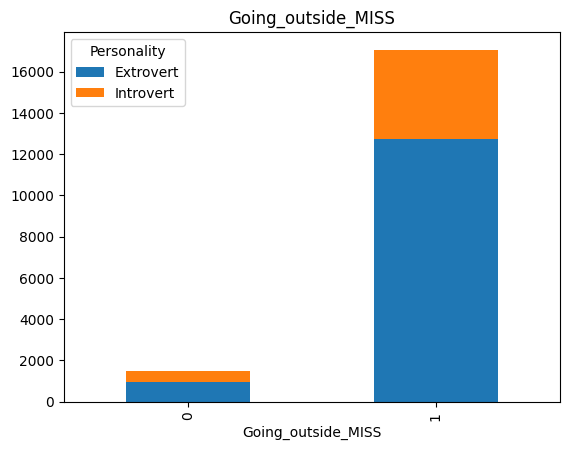

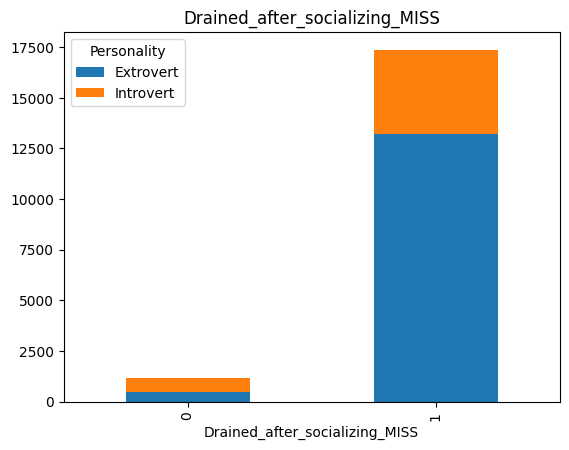

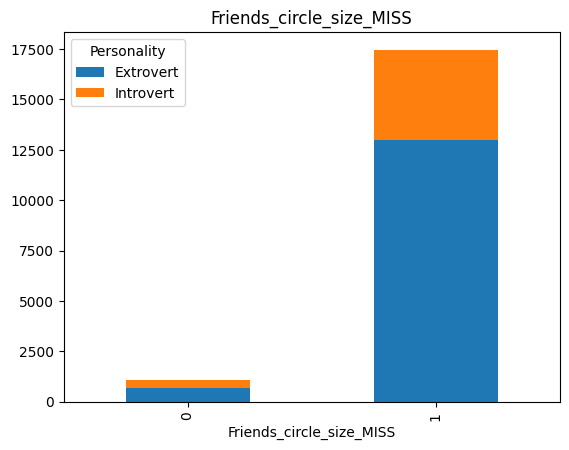

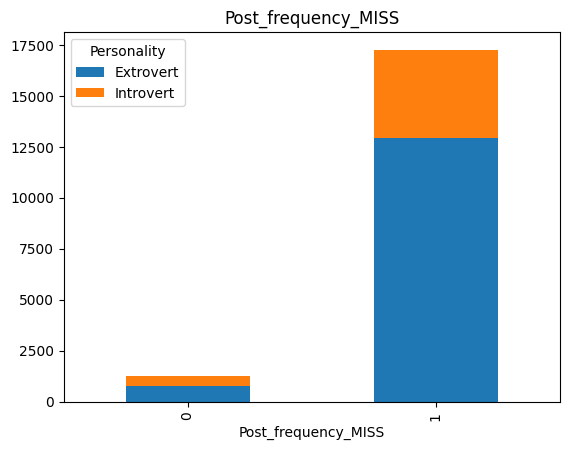

In [34]:
columns = ['Time_spent_Alone_MISS','Stage_fear_MISS', 'Social_event_attendance_MISS', 'Going_outside_MISS','Drained_after_socializing_MISS', 
           'Friends_circle_size_MISS','Post_frequency_MISS']
for col in columns:
    train_df.groupby([col,'Personality']).size().unstack().plot(kind='bar', stacked=True, title=col)
    result = pd.crosstab(train_df[col],train_df['Personality'], normalize='index')*100
    chi2, p, _, _ = chi2_contingency(result)
    print(f"Chi2 = {chi2:.3f}, p-value = {p:.4f} Column: {col} ")

### Key Observations:
- Columns Stage_fear_MISS and Drained_after_socializing_MISS have p-value lower then 0.05 so they can be considered as potential signal for different distribution of Introverts/Extroverts

## 9. Missing values - total number of non-missing data

Personality,Extrovert,Introvert
not_MISS_total,,
3,0.000000,100.000000
4,28.947368,71.052632
5,50.320924,49.679076
6,64.848324,35.151676
7,82.657768,17.342232


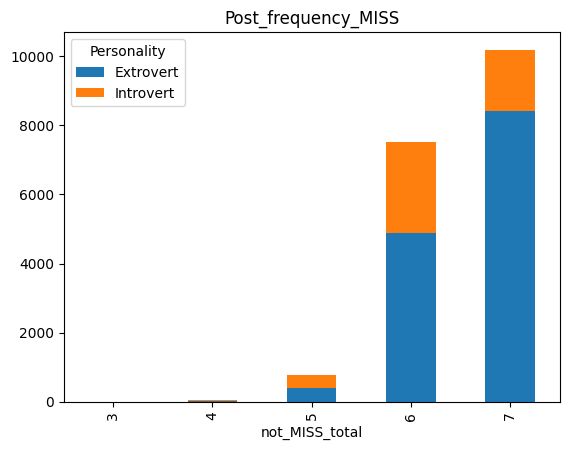

In [35]:
train_df['not_MISS_total'] = train_df[columns].sum(axis=1)
train_df.groupby(['not_MISS_total','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Data without NaN values')
pd.crosstab(train_df['not_MISS_total'],train_df['Personality'], normalize='index')*100

### Key Observations:
- When number of missing values for one person increase it is observed that percentage of introverts in such grup increases too. 

## 10. Advanced Data Imputation 

In [ ]:
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']    
cat_cols = ['Stage_fear', 'Drained_after_socializing']     

cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

train_df[cat_cols] = cat_encoder.fit_transform(train_df[cat_cols])
num_imputer = IterativeImputer(estimator=LGBMRegressor(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, verbosity=-1),
                               max_iter=10, random_state=42)

train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])
cat_imputer = IterativeImputer(estimator=LGBMClassifier(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, class_weght='balanced', verbosity=-1),
                               max_iter=10, random_state=42)

train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])

columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']
train_df[columns]=train_df[columns].round().astype(int)


## 11. Realations check between columns

### Time_spent_Alone / Going_outside

<Axes: title={'center': 'Summary'}, xlabel='Time_Alone_dev_Outside'>

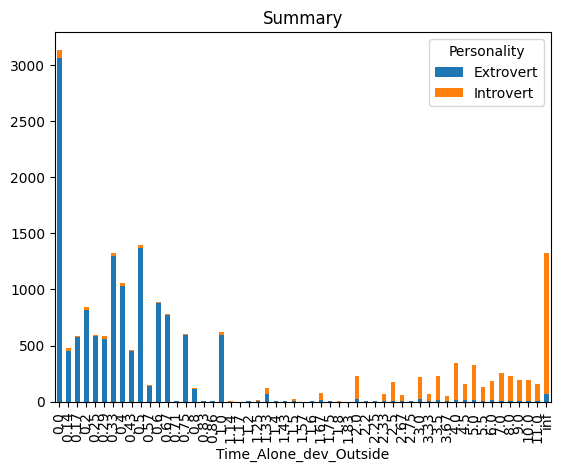

In [38]:
train_df['Time_Alone_dev_Outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].round(2).astype(float)
train_df.groupby(['Time_Alone_dev_Outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

Time_Alone_dev_Outside,0,1,2,3
Personality,,,,
Extrovert,97.153077,0.875976,1.474560,0.496387
Introvert,6.487047,3.357513,64.082902,26.072539


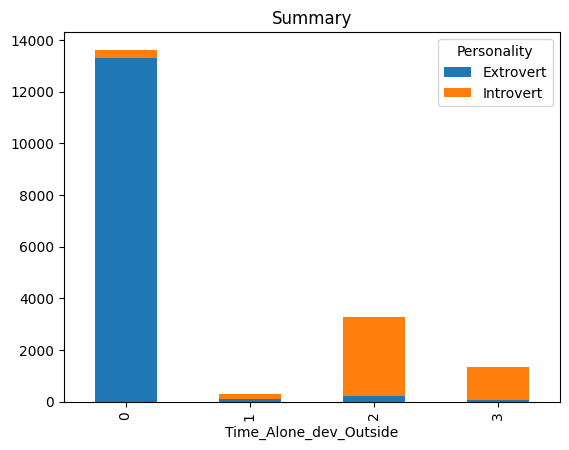

In [41]:
def Time_Alone_dev_Outside (x):
    try:
        x=float(x)
        if x <= 1:
            return 0
        elif x > 1 and x < 2:
            return 1
        elif x >= 2 and x < 100:
            return 2
        else:
            return 3
    except ValueError:
        return 3

train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].apply(Time_Alone_dev_Outside).astype('Int64')
train_df.groupby(['Time_Alone_dev_Outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df["Time_Alone_dev_Outside"],train_df['Personality'],normalize='index')*100 

### Key Observations:
- If columns Time_spent_Alone / Going_outside are devided we can observed quite good separation of data
- To reduce number of features we can use clustering or write simple function, each group have different ratio
- Can be check as additional feature to recognise groups

## Social_event_attendance / Post_frequency

<Axes: title={'center': 'Summary'}, xlabel='Social_dev_Post'>

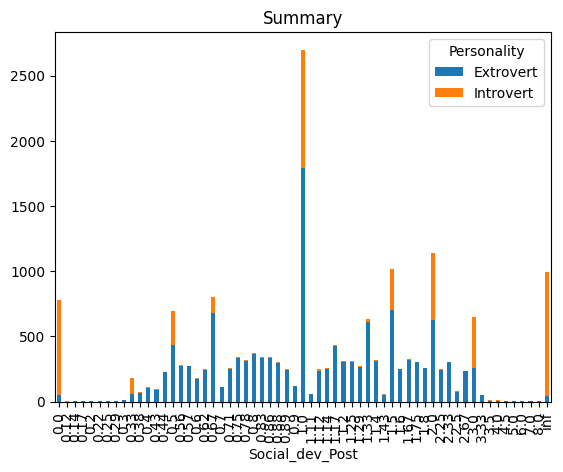

In [51]:
train_df['Social_dev_Post'] = train_df['Social_event_attendance'] / train_df['Post_frequency']
train_df['Social_dev_Post']=train_df['Social_dev_Post'].round(2).astype(float)
train_df.groupby(['Social_dev_Post','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

Social_dev_Post,0,1,2,4
Personality,,,,
Extrovert,0.810278,65.961019,2.284838,30.943865
Introvert,40.207254,5.284974,10.673575,43.834197


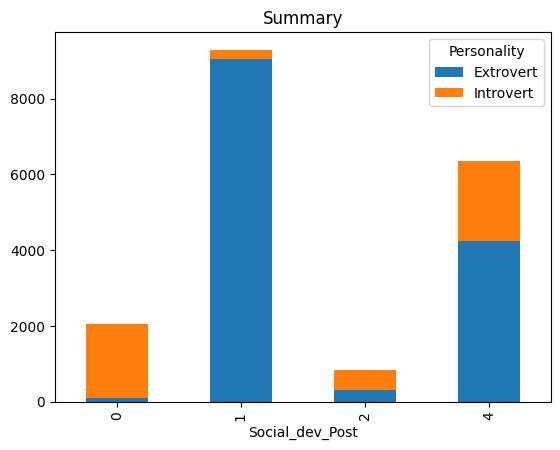

In [50]:
## Alternatywne grupowanie
train_df['Social_dev_Post'] = train_df['Social_event_attendance'] / train_df['Post_frequency']
train_df['Social_dev_Post']=train_df['Social_dev_Post'].round(2).astype(float)

def Social_dev_Post (x):
    try:
        x=float(x)
        if x == 0:
            return 0
        elif x > 0 and x < 0.33:
            return 1
        elif x == 0.33:
            return 2
        elif x > 0.33 and x < 0.5:
            return 1
        elif x == 0.5:
            return 4
        elif x > 0.5 and x < 0.67:
            return 1
        elif x == 0.67:
            return 4
        elif x > 0.67 and x < 1:
            return 1
        elif x == 1:
            return 4
        elif x > 1 and x < 1.5:
            return 1
        elif x == 1.5:
            return 4
        elif x > 1.5 and x < 2:
            return 1
        elif x == 2:
            return 4
        elif x > 2 and x < 3:
            return 1
        elif x == 3:
            return 2
        elif x > 3 and x < 100:
            return 1
        else:
            return 0
    except ValueError:
        return 0

train_df['Social_dev_Post']=train_df['Social_dev_Post'].apply(Social_dev_Post).astype('Int64')
train_df.groupby(['Social_dev_Post','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df["Social_dev_Post"],train_df['Personality'], normalize='index')*100

### Key Observations:
- If columns Social_event_attendance / Post_frequency are devided we can observed quite good separation of data in fixed points
- To reduce number of features we can use clustering or write simple function, each group have different ratio
- Can be check as additional feature to recognise groups

## Going_outside * Friends_circle_size

<Axes: title={'center': 'Summary'}, xlabel='Outside_mult_Friends'>

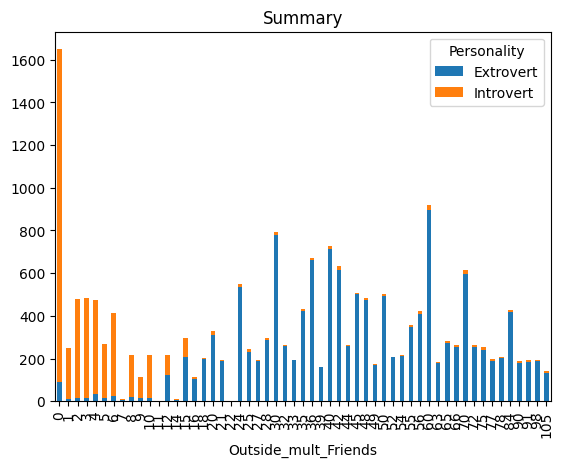

In [61]:
train_df['Outside_mult_Friends'] = train_df['Going_outside'] * train_df['Friends_circle_size']
train_df.groupby(['Outside_mult_Friends','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

Personality,Extrovert,Introvert
Outside_mult_Friends,,
0,5.690523,94.309477
1,64.299424,35.700576
2,97.543546,2.456454


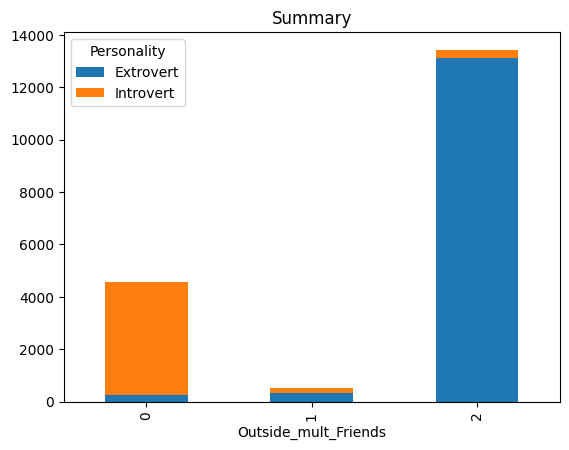

In [62]:
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= 11:
            return 0
        elif x > 11 and x <= 15:
            return 1
        elif x > 15 and x < 400:
            return 2
        else:
            return 2
    except ValueError:
        return 2

train_df['Outside_mult_Friends']=train_df['Outside_mult_Friends'].apply(Outside_mult_Friends).astype('Int64')
train_df.groupby(['Outside_mult_Friends','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df["Outside_mult_Friends"],train_df['Personality'], normalize='index')*100

### Key Observations:
- If columns Going_outside * Friends_circle_size are multiplied we can observed quite good separation of data 
- To reduce number of features we can use clustering or write simple function, each group have different ratio
- Can be check as additional feature to recognise groups

## Going_outside - Post_frequency

<Axes: title={'center': 'Summary'}, xlabel='Going_sub_Post'>

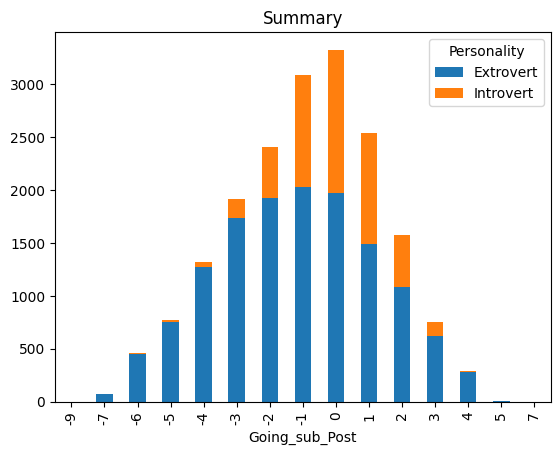

In [59]:
train_df['Going_sub_Post']=train_df['Going_outside'] - train_df['Post_frequency']
train_df.groupby(['Going_sub_Post','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

Personality,Extrovert,Introvert
Going_sub_Post,,
0,98.499062,1.500938
1,96.895973,3.104027
2,88.385163,11.614837
3,75.836057,24.163943
4,61.253211,38.746789
5,62.500000,37.500000


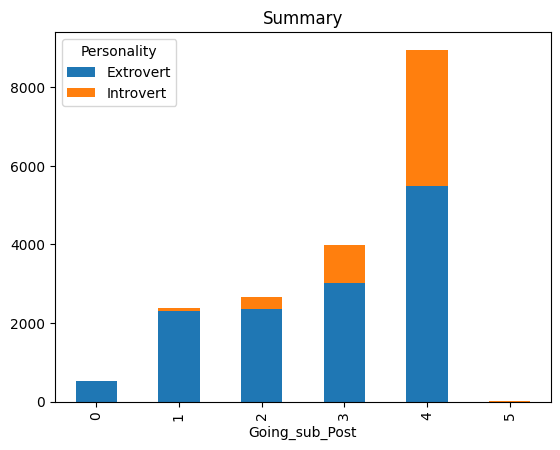

In [60]:
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= -6:
            return 0
        elif x == -5 or x== -4 or x==4:
            return 1
        elif x == -3 or x== 3:
            return 2
        elif x == -2 or x== 2:
            return 3
        elif x == -1 or x== 0 or x==1:
            return 4
        elif x >= 5:
            return 5
        else:
            return 6
    except ValueError:
        return 6

train_df['Going_sub_Post']=train_df['Going_sub_Post'].apply(Outside_mult_Friends).astype('Int64')
train_df.groupby(['Going_sub_Post','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')
pd.crosstab(train_df["Going_sub_Post"],train_df['Personality'], normalize='index')*100

### Key Observations:
- If columns Going_outside - Post_frequency are subtracted from each other we can observed quite good separation of data 
- To reduce number of features we can use clustering or write simple function, each group have different ratio
- Can be check as additional feature to recognise groups
- group 0 is still not pure group

## 11. Realations check between columns - Other 

## Columns subtraction

<Axes: title={'center': 'Summary'}, xlabel='subtraction'>

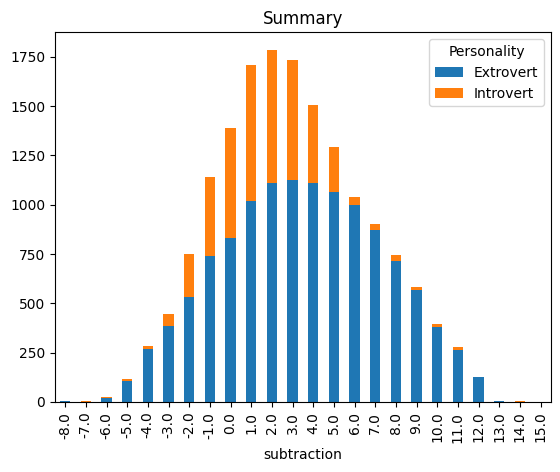

In [47]:
train_df['subtraction']=train_df['Friends_circle_size'] - train_df['Post_frequency']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

<Axes: title={'center': 'Summary'}, xlabel='subtraction'>

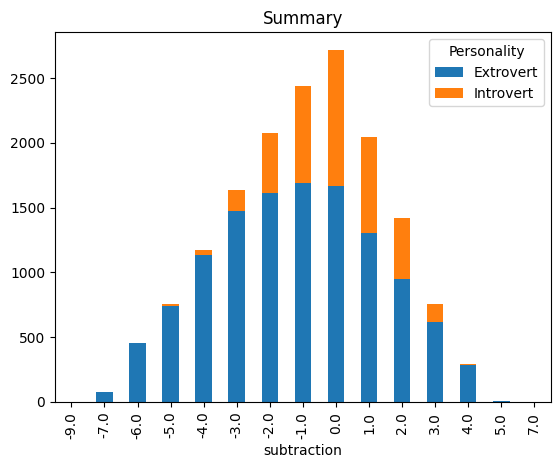

In [48]:
train_df['subtraction']=train_df['Going_outside'] - train_df['Post_frequency']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

<Axes: title={'center': 'Summary'}, xlabel='subtraction'>

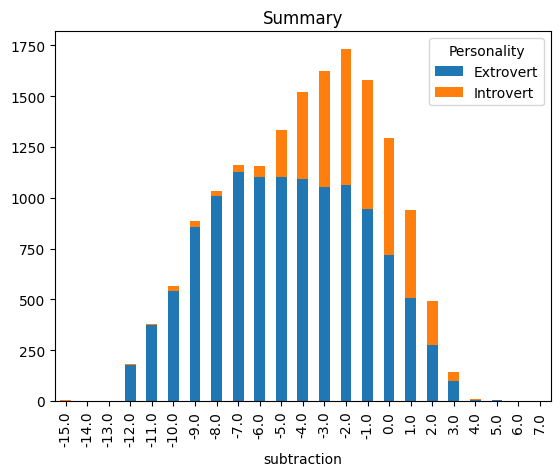

In [49]:
train_df['subtraction']=train_df['Going_outside'] - train_df['Friends_circle_size']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

<Axes: title={'center': 'Summary'}, xlabel='subtraction'>

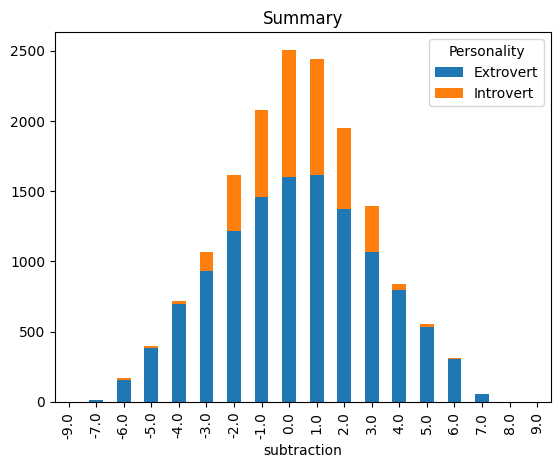

In [50]:
train_df['subtraction']=train_df['Social_event_attendance'] - train_df['Post_frequency']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

<Axes: title={'center': 'Summary'}, xlabel='subtraction'>

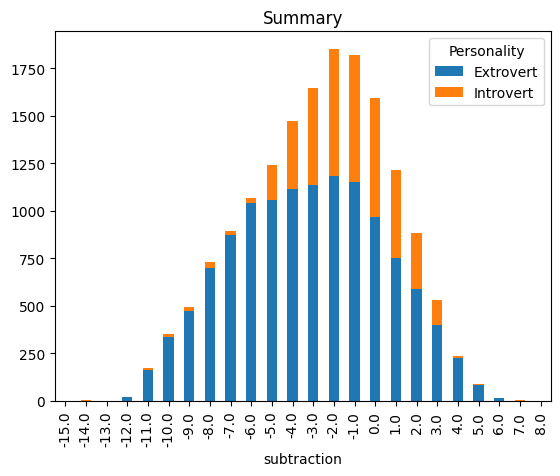

In [51]:
train_df['subtraction']=train_df['Social_event_attendance'] - train_df['Friends_circle_size']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

<Axes: title={'center': 'Summary'}, xlabel='subtraction'>

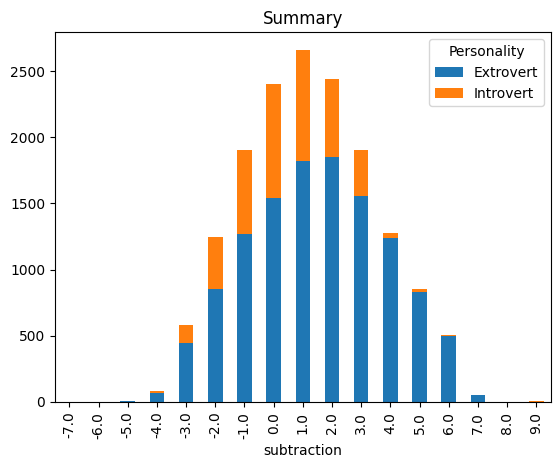

In [52]:
train_df['subtraction']=train_df['Social_event_attendance'] - train_df['Going_outside']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

<Axes: title={'center': 'Summary'}, xlabel='subtraction'>

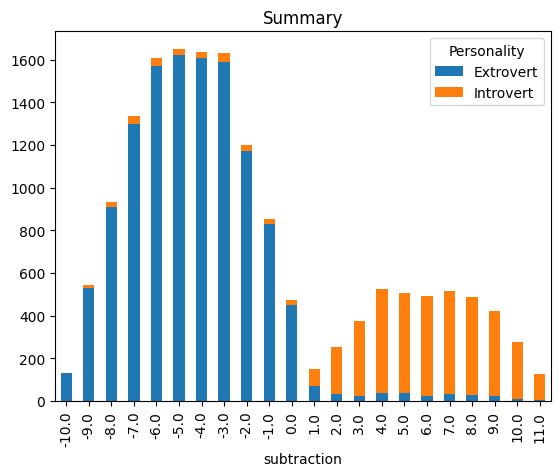

In [53]:
train_df['subtraction']=train_df['Time_spent_Alone'] - train_df['Post_frequency']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

<Axes: title={'center': 'Summary'}, xlabel='subtraction'>

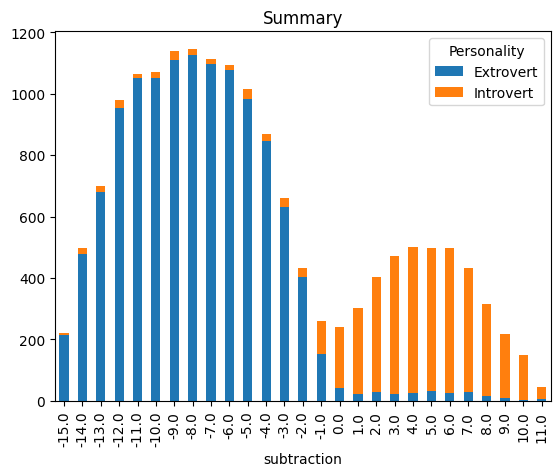

In [54]:
train_df['subtraction']=train_df['Time_spent_Alone'] - train_df['Friends_circle_size']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

<Axes: title={'center': 'Summary'}, xlabel='subtraction'>

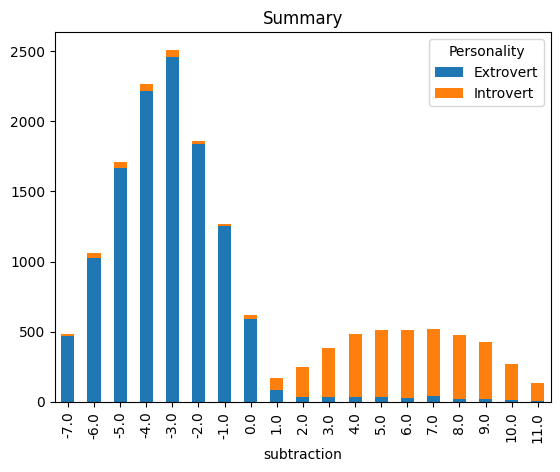

In [55]:
train_df['subtraction']=train_df['Time_spent_Alone'] - train_df['Going_outside']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

<Axes: title={'center': 'Summary'}, xlabel='subtraction'>

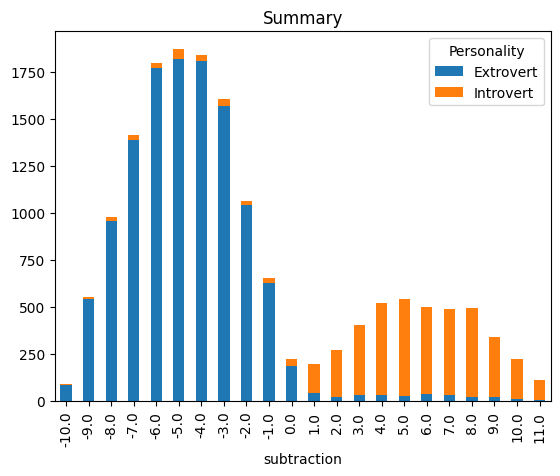

In [56]:
train_df['subtraction']=train_df['Time_spent_Alone'] - train_df['Social_event_attendance']
train_df.groupby(['subtraction','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

## Column summing

<Axes: title={'center': 'Summary'}, xlabel='Summary'>

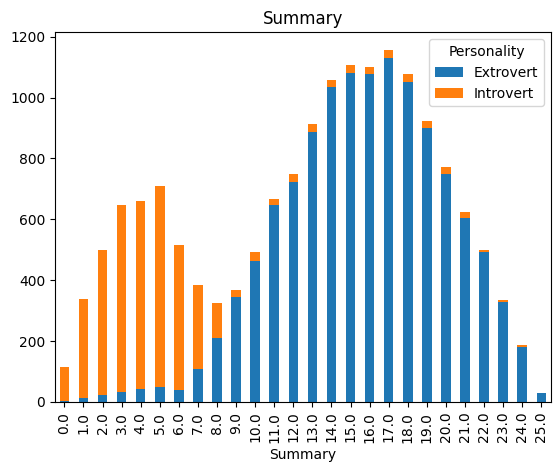

In [58]:
train_df['Summary']=train_df['Friends_circle_size'] + train_df['Post_frequency']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

<Axes: title={'center': 'Summary'}, xlabel='Summary'>

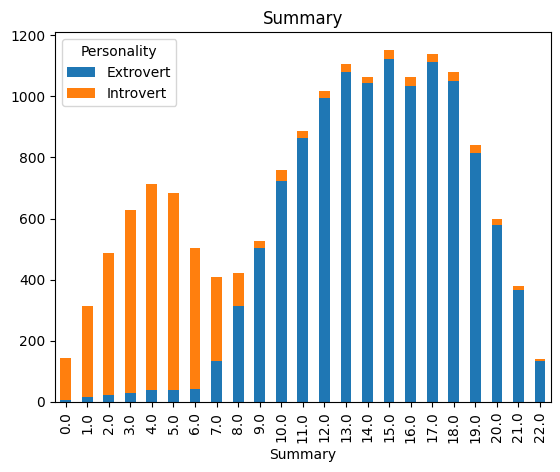

In [59]:
train_df['Summary']=train_df['Going_outside'] + train_df['Friends_circle_size']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

<Axes: title={'center': 'Summary'}, xlabel='Summary'>

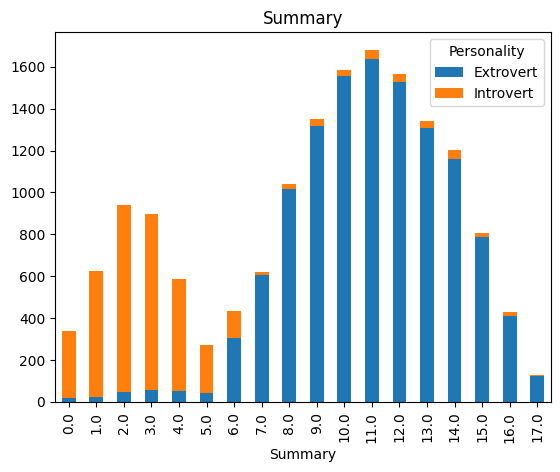

In [60]:
train_df['Summary']=train_df['Going_outside'] + train_df['Post_frequency']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

<Axes: title={'center': 'Summary'}, xlabel='Summary'>

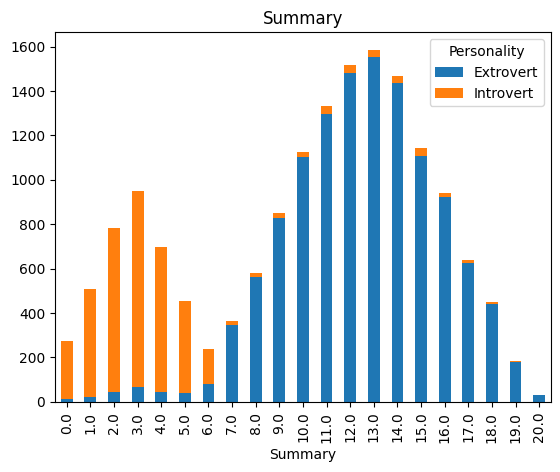

In [61]:
train_df['Summary']=train_df['Social_event_attendance'] + train_df['Post_frequency']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

<Axes: title={'center': 'Summary'}, xlabel='Summary'>

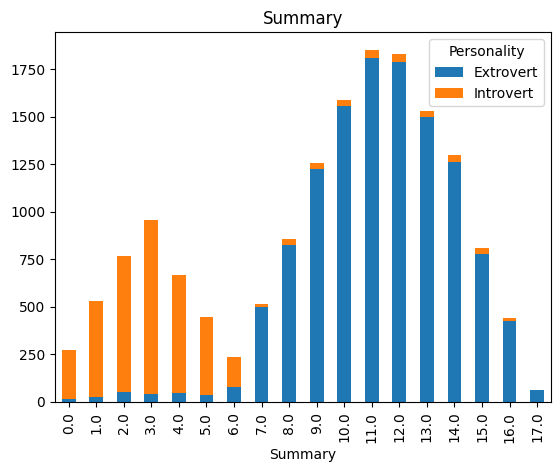

In [62]:
train_df['Summary']=train_df['Social_event_attendance'] + train_df['Going_outside']
train_df.groupby(['Summary','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

## Other column multiplications and divisions

<Axes: title={'center': 'Summary'}, xlabel='Social_event_outside'>

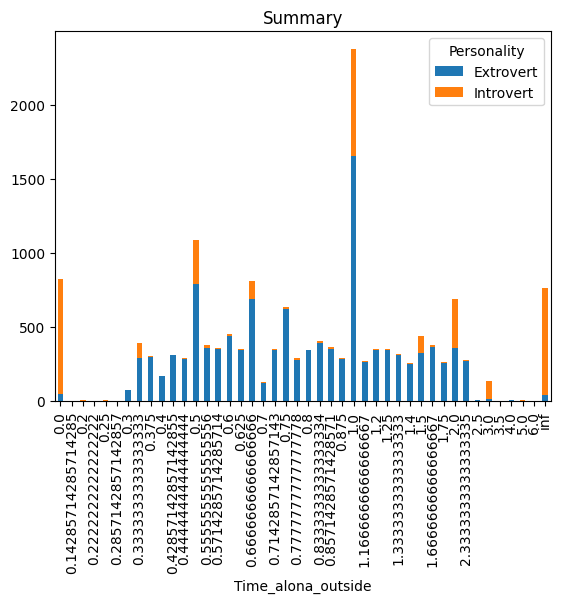

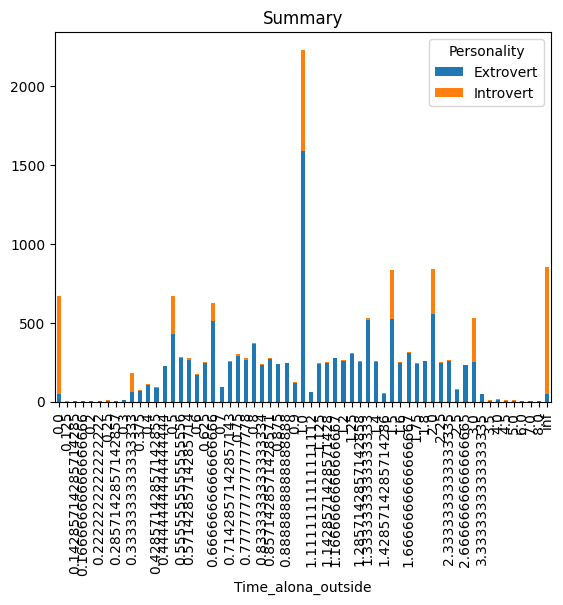

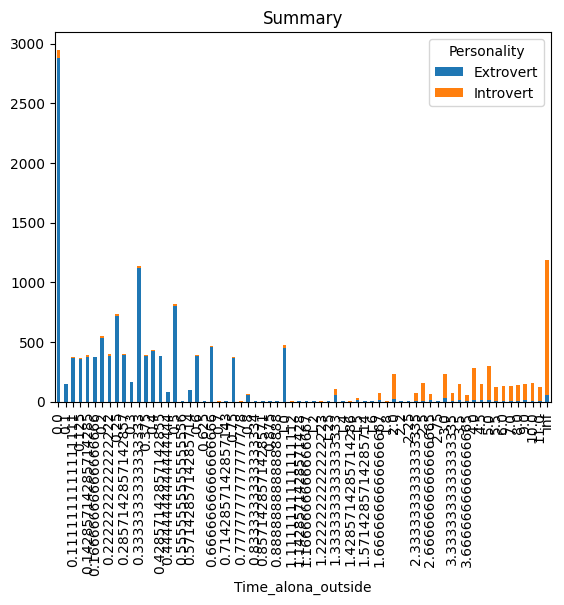

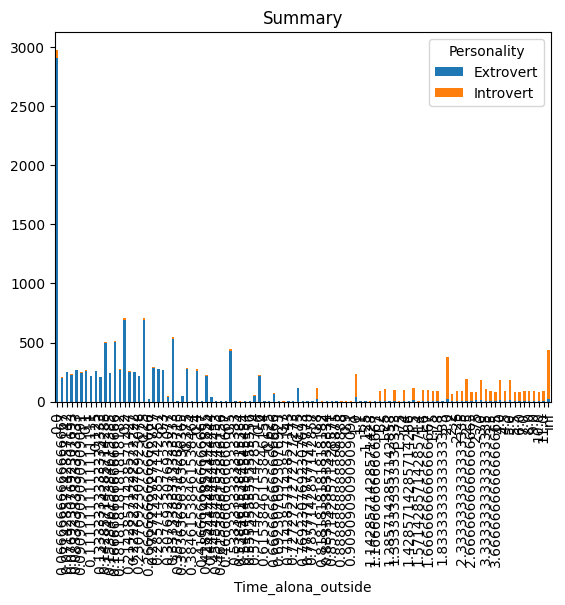

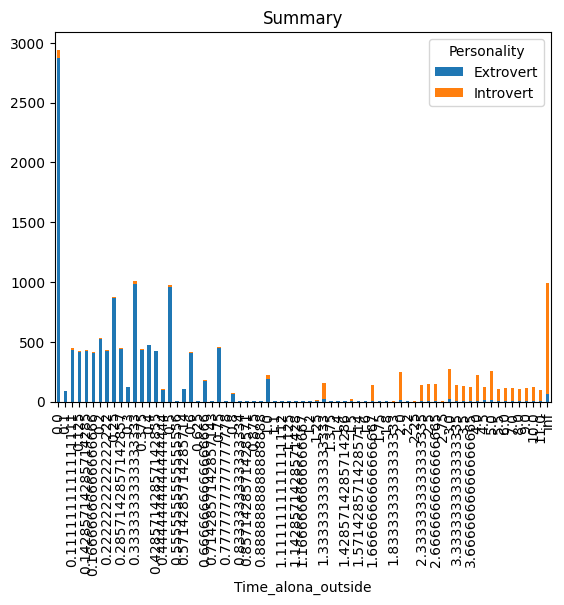

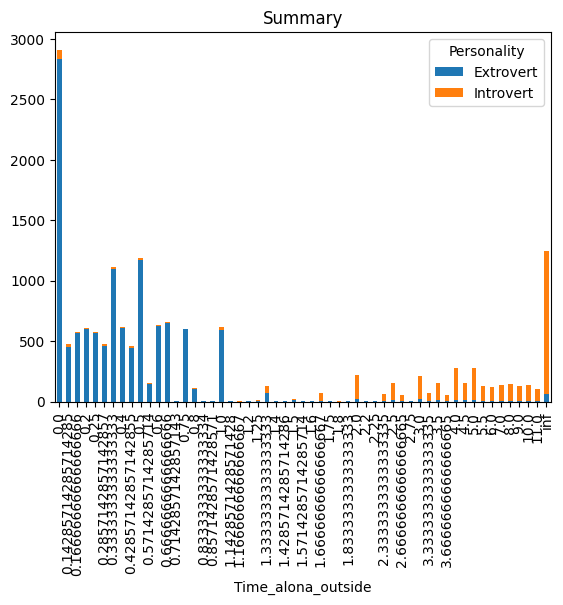

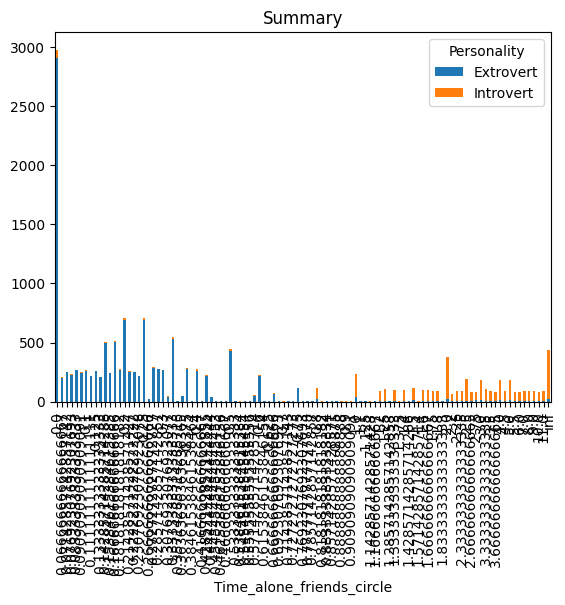

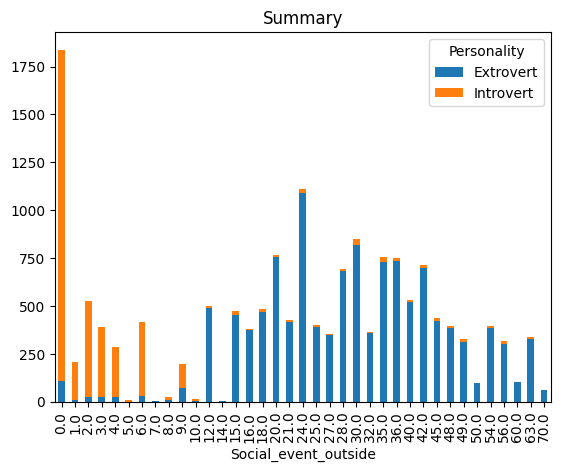

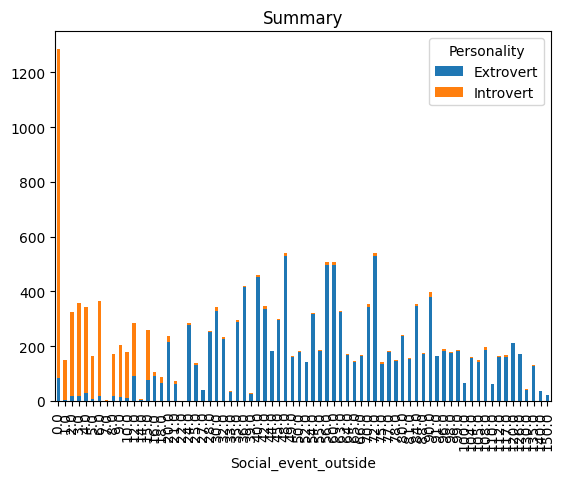

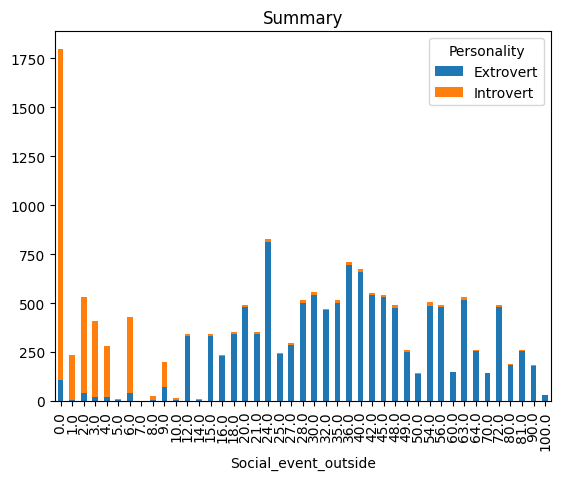

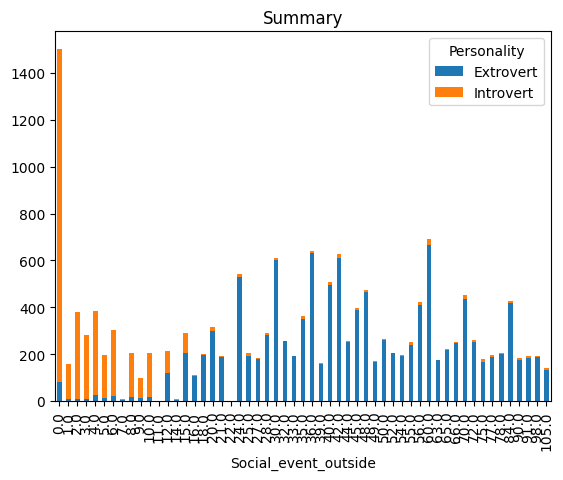

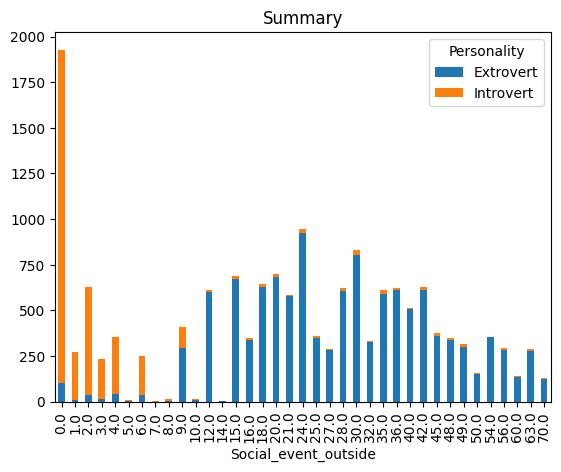

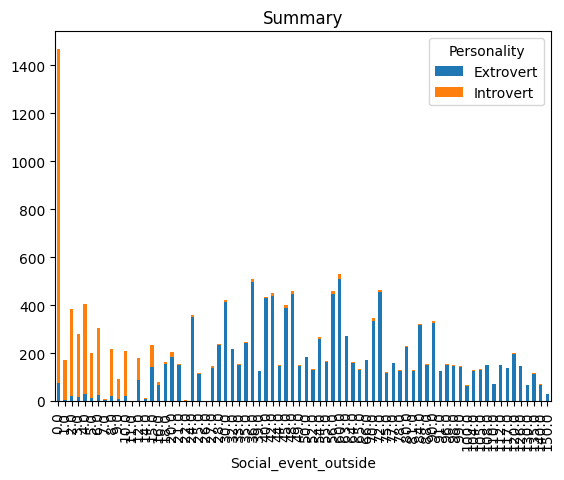

In [63]:
train_df['Time_alona_outside'] = train_df['Going_outside'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Social_event_attendance'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Post_frequency']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Friends_circle_size']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Social_event_attendance']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alona_outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df.groupby(['Time_alona_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Time_alone_friends_circle'] = train_df['Time_spent_Alone'] / train_df['Friends_circle_size']
train_df.groupby(['Time_alone_friends_circle','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Social_event_attendance']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Social_event_attendance'] * train_df['Friends_circle_size']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Social_event_attendance'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Friends_circle_size']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


train_df['Social_event_outside'] = train_df['Going_outside'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')

train_df['Social_event_outside'] = train_df['Friends_circle_size'] * train_df['Post_frequency']
train_df.groupby(['Social_event_outside','Personality']).size().unstack().plot(kind='bar', stacked=True, title='Summary')


### Key Observations:
- For checked interactions there is no pure separation between Extroverts and Introverts
- Some additional features can be created to be tested, if there is improvement in classification
